In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Mounted at /content/drive


In [ ]:
import os
import random
import time
import platform
import matplotlib.pyplot as plt

import numpy as np
from sklearn import metrics
import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets, utils
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 33.4MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/pyth

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [ ]:
# Número de classes
num_classes = 2

class_names = ['True', 'False']

# Tamanho do lote (mini-batch)
batch_size = 64

# Taxa de aprendizado
lr = 0.001

# Mommentum
mm = 0.9

# Número de épocas
epochs = 30 # Usar durante o desenvolvimento
### epochs = 50

In [ ]:
if IN_COLAB:
    ds_path = '/content/drive/MyDrive/RDC2/'
else:
    ds_path = 'data/RDC2/'

In [ ]:
# Treinamento
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    ### transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # Média e desvio padrão do ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(ds_path, transform=data_transforms)

In [ ]:
# Conjunto de treinamento: 80 %
train_size = int(0.6 * len(full_dataset))

val_size = int( 0.5 *   (len(full_dataset) - train_size))
# Conjunto de teste: 20 %
test_size = int(len(full_dataset) - train_size - val_size)

# Spliting the full dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
# Número de imagens em cada dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)


# DEBUG
print(train_size)
print(val_size)
print(test_size)

# Definindo os dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

1920
640
640


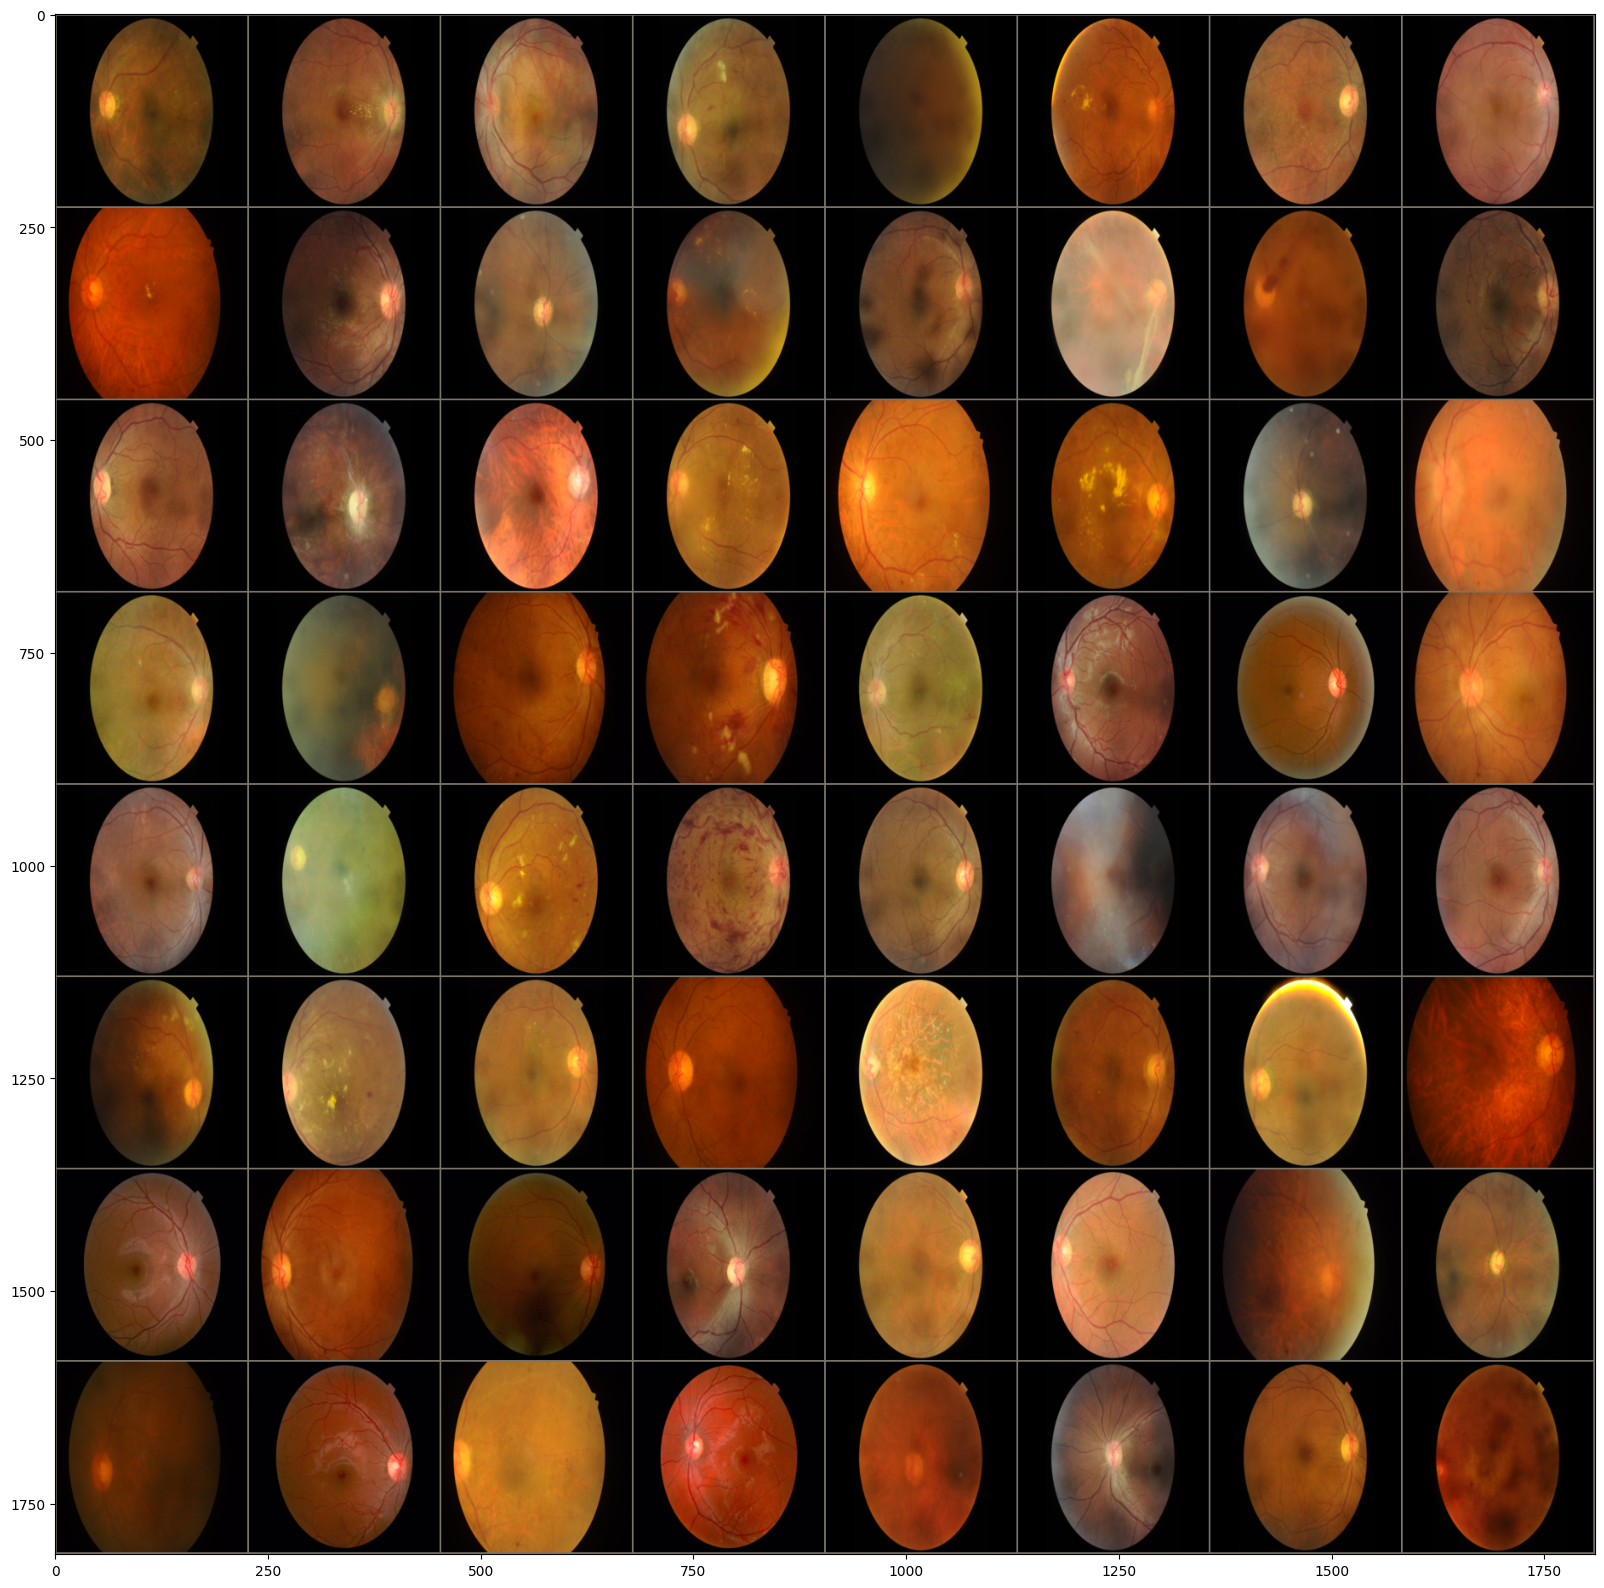

In [ ]:
def show_transformed_image(image):
    # Unnormalize all channels
    ### for t, m, s in zip(np_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): # (ImageNet weights)
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualizar 'batch_size' imagens
dataloader_vis = torch.utils.data.DataLoader(dataset=full_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
for image, label in items:
    pass

show_transformed_image(utils.make_grid(image))

# Modelo AlexNet

In [ ]:
### model_ft = models.alexnet(pretrained=True)
model_ft = models.alexnet(weights='AlexNet_Weights.DEFAULT')

# Altera o número de neurônios na cadama de saída.
model_ft.classifier[6] = nn.Linear(4096, num_classes)

In [ ]:
# Simple net
### model = Net(3, 5)

# Pretrainned
model = model_ft

In [ ]:
# Envia o modelo para a GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Imprime o modelo
print(str(model))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Loss function and optimizer alexnet



In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

Training the model alexnet

In [ ]:
'''optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)'''

'optimizer = optim.SGD(model.parameters(), lr=0.1)\nscheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)'

In [ ]:
# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino
    model_ft.train()

    # Perda (loss) nesta época
    loss_epoch_train = 0
    # Amostras classificadas corretamente nesta época
    num_hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels in train_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # FORWARD
        # ------>
        # Habilita o cálculo do gradiente
        torch.set_grad_enabled(True)

        # Saída do modelo para o lote
        outputs = model_ft(inputs)

        # 'outputs' está em porcentagens. Tomar os maximos como resposta.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Atualiza o número de amostras classificadas corretamente na época.
        num_hits_epoch_train += torch.sum(preds == labels.data)

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(num_hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model_ft.eval()

    # Pego o numero de perda e o numero de acertos
    loss_epoch_val = 0.0 # Atual perda
    num_hits_epoch_val = 0 # Numero de itens corretos

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False)

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model_ft(inputs)

        # Retorna a maior predicao.
        #### _, preds = torch.max(outputs, 1)
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # # Atualiza os acertos da época
        num_hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    ###scheduler.step()

    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(num_hits_epoch_val.double() / val_size)

    # Store loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print('Epoch {}/{} - TRAIN Loss: {:.4f} TRAIN Acc: {:.4f} - VAL. Loss: {:.4f} VAL. Acc: {:.4f} ({:.4f} seconds)'.format(epoch, epochs - 1, train_loss, train_acc, val_loss, val_acc, time_epoch))

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print('\nTreinamento finalizado. ({0}m and {1}s)'.format(int(time_total_train // 60), int(time_total_train % 60)))

Epoch 0/29 - TRAIN Loss: 0.5615 TRAIN Acc: 0.7578 - VAL. Loss: 0.4156 VAL. Acc: 0.7938 (407.0525 seconds)
Epoch 1/29 - TRAIN Loss: 0.3572 TRAIN Acc: 0.8391 - VAL. Loss: 0.3157 VAL. Acc: 0.8422 (393.8661 seconds)
Epoch 2/29 - TRAIN Loss: 0.3071 TRAIN Acc: 0.8562 - VAL. Loss: 0.2861 VAL. Acc: 0.8547 (397.1651 seconds)
Epoch 3/29 - TRAIN Loss: 0.2843 TRAIN Acc: 0.8651 - VAL. Loss: 0.2717 VAL. Acc: 0.8609 (398.4264 seconds)
Epoch 4/29 - TRAIN Loss: 0.2567 TRAIN Acc: 0.8859 - VAL. Loss: 0.2752 VAL. Acc: 0.8563 (398.5969 seconds)
Epoch 5/29 - TRAIN Loss: 0.2488 TRAIN Acc: 0.8828 - VAL. Loss: 0.2602 VAL. Acc: 0.8828 (402.2155 seconds)
Epoch 6/29 - TRAIN Loss: 0.2306 TRAIN Acc: 0.8927 - VAL. Loss: 0.2683 VAL. Acc: 0.8703 (400.8835 seconds)
Epoch 7/29 - TRAIN Loss: 0.2169 TRAIN Acc: 0.8964 - VAL. Loss: 0.2660 VAL. Acc: 0.8766 (401.3337 seconds)
Epoch 8/29 - TRAIN Loss: 0.2166 TRAIN Acc: 0.9047 - VAL. Loss: 0.2536 VAL. Acc: 0.8781 (397.4800 seconds)
Epoch 9/29 - TRAIN Loss: 0.2092 TRAIN Acc: 0.9

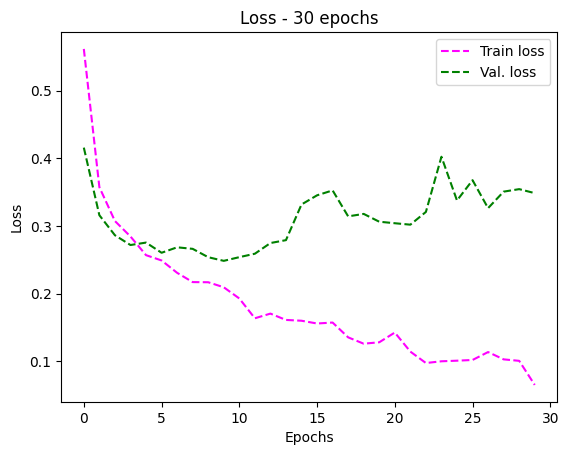

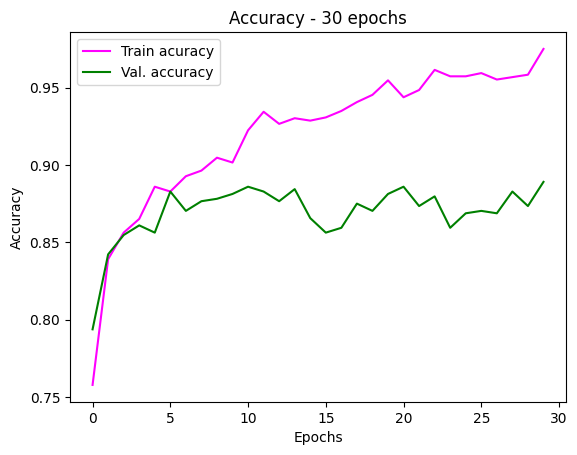

In [ ]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Titulo - Loss and accuracy chart
loss_title = 'Loss - ' + str(epochs) + ' epochs'
acc_title = 'Accuracy - ' + str(epochs) + ' epochs'

# Plot - Loss
plt.figure()
plt.title(loss_title)
plt.plot(epochs_list, train_loss_list, c='magenta' ,ls='--', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green' ,ls='--', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('curva_perda_alexnet.pdf')

# Plot - Accuracy
plt.figure()
plt.title(acc_title)
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('curva_acuracia_alexnet.pdf')

In [ ]:
# Lista com as classes reais e classes preditas
true_val_list = []
pred_val_list = []
# Lista com as probabilidades
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, labelList) in enumerate(val_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        labelList = labelList.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    ### _, preds = torch.max(output, 1)
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    prob_val_batch = np.asarray(outputs_prob.cpu())

    # Classes reais true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_val_batch = np.asarray(labelList.cpu())
        pred_val_batch = np.asarray(preds.cpu())

    # Itera ao longo do lote
    for i in range(0, len(pred_val_batch)):
        true_val_list.append(true_val_batch[i])
        pred_val_list.append(pred_val_batch[i])

        prob_val_list.append(prob_val_batch[i])

In [ ]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix ( validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list,
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix ( validation)
[[102  30]
 [ 41 467]]

Class. report (validation)
              precision    recall  f1-score   support

        True     0.7133    0.7727    0.7418       132
       False     0.9396    0.9193    0.9294       508

    accuracy                         0.8891       640
   macro avg     0.8265    0.8460    0.8356       640
weighted avg     0.8930    0.8891    0.8907       640



Validation Acc.: 0.8891


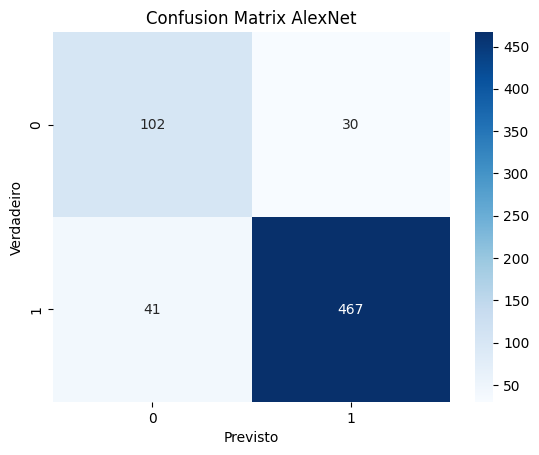

In [ ]:
import seaborn as sns
# Nomes das classes
data = [[102, 30], [41, 467]]
# Configurar subplots

sns.heatmap(data, cmap='Blues', annot=True, fmt='g')

# Adicionando título, rótulos do eixo x e y
plt.title('Confusion Matrix AlexNet')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')

# Mostrando o heatmap
plt.show()